# Sachs

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightning as L
import torch
import os, sys
import numpy as np
import pickle
sys.path.append("/home/younsuk/causal_cbm/")
from src.data.datasets.bndataset import BNDataset
import networkx as nx


In [ ]:
task_name = "Akt"
BND = BNDataset(dag_name = 'sachs', task_name = "Akt",
                dataset_n_samples = 10000,
                test_size = 0.2,
                val_size = 0.1)

BND.split()
train = BND.data['train']
val = BND.data['val']
test = BND.data['test']



## gragh check

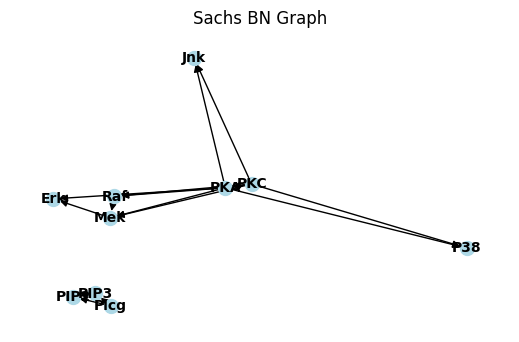

In [64]:
adj_pd = BND.load_ground_truth_graph()

#remove task_name from adj_pd ; column and row
adj_pd = adj_pd.drop(task_name, axis=0).drop(task_name, axis=1)

graph_sachs = nx.from_pandas_adjacency(adj_pd, create_using=nx.DiGraph)

# Plot the graph
plt.figure(figsize=(5, 3))
nx.draw(graph_sachs, with_labels=True, node_color='lightblue', node_size=100, font_size=10, font_weight='bold')
plt.title('Sachs BN Graph')
plt.show()

In [65]:

order = adj_pd.index.tolist()
topo_order = list(nx.topological_sort(graph_sachs))
print("Topological order of nodes:", topo_order)
print("Before topological order:", order)

topo_order_idx = [order.index(node) for node in topo_order]

# rearrange adj_pd with topo_order
adj_pd_topo = adj_pd.loc[topo_order, topo_order]
print(adj_pd_topo)
print(adj_pd)

adj_cnf = adj_pd_topo.to_numpy(dtype=np.int8).transpose(1,0)
adj_cnf += np.eye(adj_cnf.shape[0], dtype=np.int8)
adj_cnf



Topological order of nodes: ['PKC', 'Plcg', 'PKA', 'PIP3', 'Jnk', 'Raf', 'P38', 'PIP2', 'Mek', 'Erk']
Before topological order: ['Erk', 'PKA', 'Mek', 'Jnk', 'PKC', 'Raf', 'P38', 'PIP3', 'PIP2', 'Plcg']
target  PKC  Plcg  PKA  PIP3  Jnk  Raf  P38  PIP2  Mek  Erk
source                                                     
PKC       0     0    1     0    1    1    1     0    1    0
Plcg      0     0    0     1    0    0    0     1    0    0
PKA       0     0    0     0    1    1    1     0    1    1
PIP3      0     0    0     0    0    0    0     1    0    0
Jnk       0     0    0     0    0    0    0     0    0    0
Raf       0     0    0     0    0    0    0     0    1    0
P38       0     0    0     0    0    0    0     0    0    0
PIP2      0     0    0     0    0    0    0     0    0    0
Mek       0     0    0     0    0    0    0     0    0    1
Erk       0     0    0     0    0    0    0     0    0    0
target  Erk  PKA  Mek  Jnk  PKC  Raf  P38  PIP3  PIP2  Plcg
source            

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 1]], dtype=int8)

## CNF Learning and Inference on Sachs dataset

### Data check

In [113]:

def post_process(x, binary_dims, binary_min_values, binary_max_values, inplace=False):
    if not inplace:
        x = x.clone()
    x[..., binary_dims] = x[..., binary_dims].floor().float()
    x[..., binary_dims] = torch.clamp(x[..., binary_dims], min=binary_min_values, max=binary_max_values)

    return x

def add_noise(x):
    # Calculate the standard deviation of each column
    std = torch.std(x, dim=0).mul(100).round() / 100.0

    # Find the columns that are constant (i.e., have a standard deviation of 0)
    constant_mask = std == 0
    # # Generate a small amount of noise for each constant column
    # noise = torch.rand(x.shape[0], sum(constant_mask)) * 2.0 - 1.0
    noise = torch.randn(x.shape[0], sum(constant_mask))
    # Add the noise to the corresponding columns
    x[:, constant_mask] += noise * 0.01
    return x

In [116]:
# dataset as tensor
train_C = torch.tensor(train.c)
train_Y = torch.tensor(train.y)
print(train_C.shape, train_Y.shape)

test_C = torch.tensor(test.c)
test_Y = torch.tensor(test.y)
print(test_C.shape, test_Y.shape)

val_C = torch.tensor(val.c)
val_Y = torch.tensor(val.y)
val_C.shape, val_Y.shape


##preprocessing

#column-wise rearrange as topological order (topo_order_idx)
train_C_topo = train_C[:,topo_order_idx]
test_C_topo = test_C[:,topo_order_idx]
val_C_topo = val_C[:,topo_order_idx]

train_C_topo.shape, test_C_topo.shape, val_C_topo.shape


# binary idx
binary_dims = list(range(0, 10))
binary_min_values = train_C[:, binary_dims].min(dim=0)[0]
binary_max_values = train_C[:, binary_dims].max(dim=0)[0]

#dequantization
train_C_topo_deq = train_C_topo[:, binary_dims] + torch.rand_like(train_C_topo[:, binary_dims])
test_C_topo_deq = test_C_topo[:, binary_dims] + torch.rand_like(test_C_topo[:, binary_dims])
val_C_topo_deq = val_C_topo[:, binary_dims] + torch.rand_like(val_C_topo[:, binary_dims])
print(train_C_topo_deq.shape, test_C_topo_deq.shape, val_C_topo_deq.shape)

def create_df(tensors_dict):
    df_list = []
    for i, (k, x) in enumerate(tensors_dict.items()):
        df = pd.DataFrame(x.numpy(), columns=[f'$x_{j}$' for j in range(x.shape[1])])
        df['name'] = k
        df_list.append(df)

    df = pd.concat(df_list)
    return df


def plot_data(tensors_dict, mode = "kde"):
    df = create_df(tensors_dict)
    g = sns.PairGrid(df, diag_sharey=False, hue='name')
    g.map_upper(sns.scatterplot, s=15, alpha=0.5)
    if mode == "kde":
        g.map_lower(sns.kdeplot, common_norm=False)
        g.map_diag(sns.kdeplot, lw=2, common_norm=False)
    elif mode == "hist":
        g.map_lower(sns.histplot, bins=20)
        g.map_diag(sns.histplot, bins=20)
    g.add_legend()
    plt.show()



# plot_data({'Data': test_C_topo_deq}, "kde")

torch.Size([7000, 10]) torch.Size([7000, 1])
torch.Size([2000, 10]) torch.Size([2000, 1])
torch.Size([7000, 10]) torch.Size([2000, 10]) torch.Size([1000, 10])


### Training

In [91]:

from torch.utils.data import DataLoader, TensorDataset
# Create the dataloaders
batch_size = 100
train_dataset = TensorDataset(train_C_topo_deq)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

test_dataset = TensorDataset(test_C_topo_deq)
test_loader = DataLoader(test_dataset, batch_size=test_C_topo_deq.shape[0])

In [92]:
from causalflows.flows import CausalMAF

features = 10
context = 0
flow = CausalMAF(features, context, adjacency=adj_cnf)


from lightning.pytorch.loggers.logger import Logger
from lightning.pytorch.utilities import rank_zero_only


class MyLogger(Logger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.values = {}

    @property
    def name(self):
        return "MyLogger"

    @property
    def version(self):
        # Return the experiment version, int or str.
        return "0.1"

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        for k, v in metrics.items():
            if k in self.values:
                self.values[k].append(v)
            else:
                self.values[k] = [v]

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        pass

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass

class LitFlow(L.LightningModule):
    def __init__(self, flow):
        super().__init__()
        self.flow = flow

    def training_step(self, batch, batch_idx):
        x = batch[0]
        loss = -self.flow().log_prob(x).mean()
        self.log('train_loss', loss.detach())
        self.log('log_prob', -loss.detach())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
model = LitFlow(flow)

logger = MyLogger()
trainer = L.Trainer(
    max_epochs=200, logger=logger, enable_checkpointing=False, log_every_n_steps=len(train_loader)
)
trainer.fit(model=model, train_dataloaders=train_loader)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type      | Params | Mode  | FLOPs
---------------------------------------------------
0 | flow | CausalMAF | 6.2 K  | train | 0    
---------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


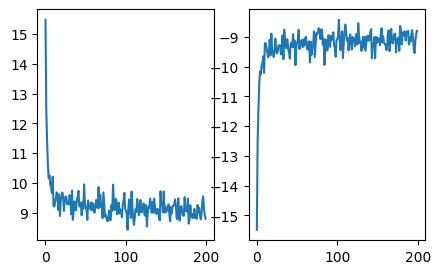

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
sns.lineplot(x=logger.values['epoch'], y=logger.values['train_loss'], ax=axs[0])
sns.lineplot(x=logger.values['epoch'], y=logger.values['log_prob'], ax=axs[1])
plt.show()

### Inference

observational

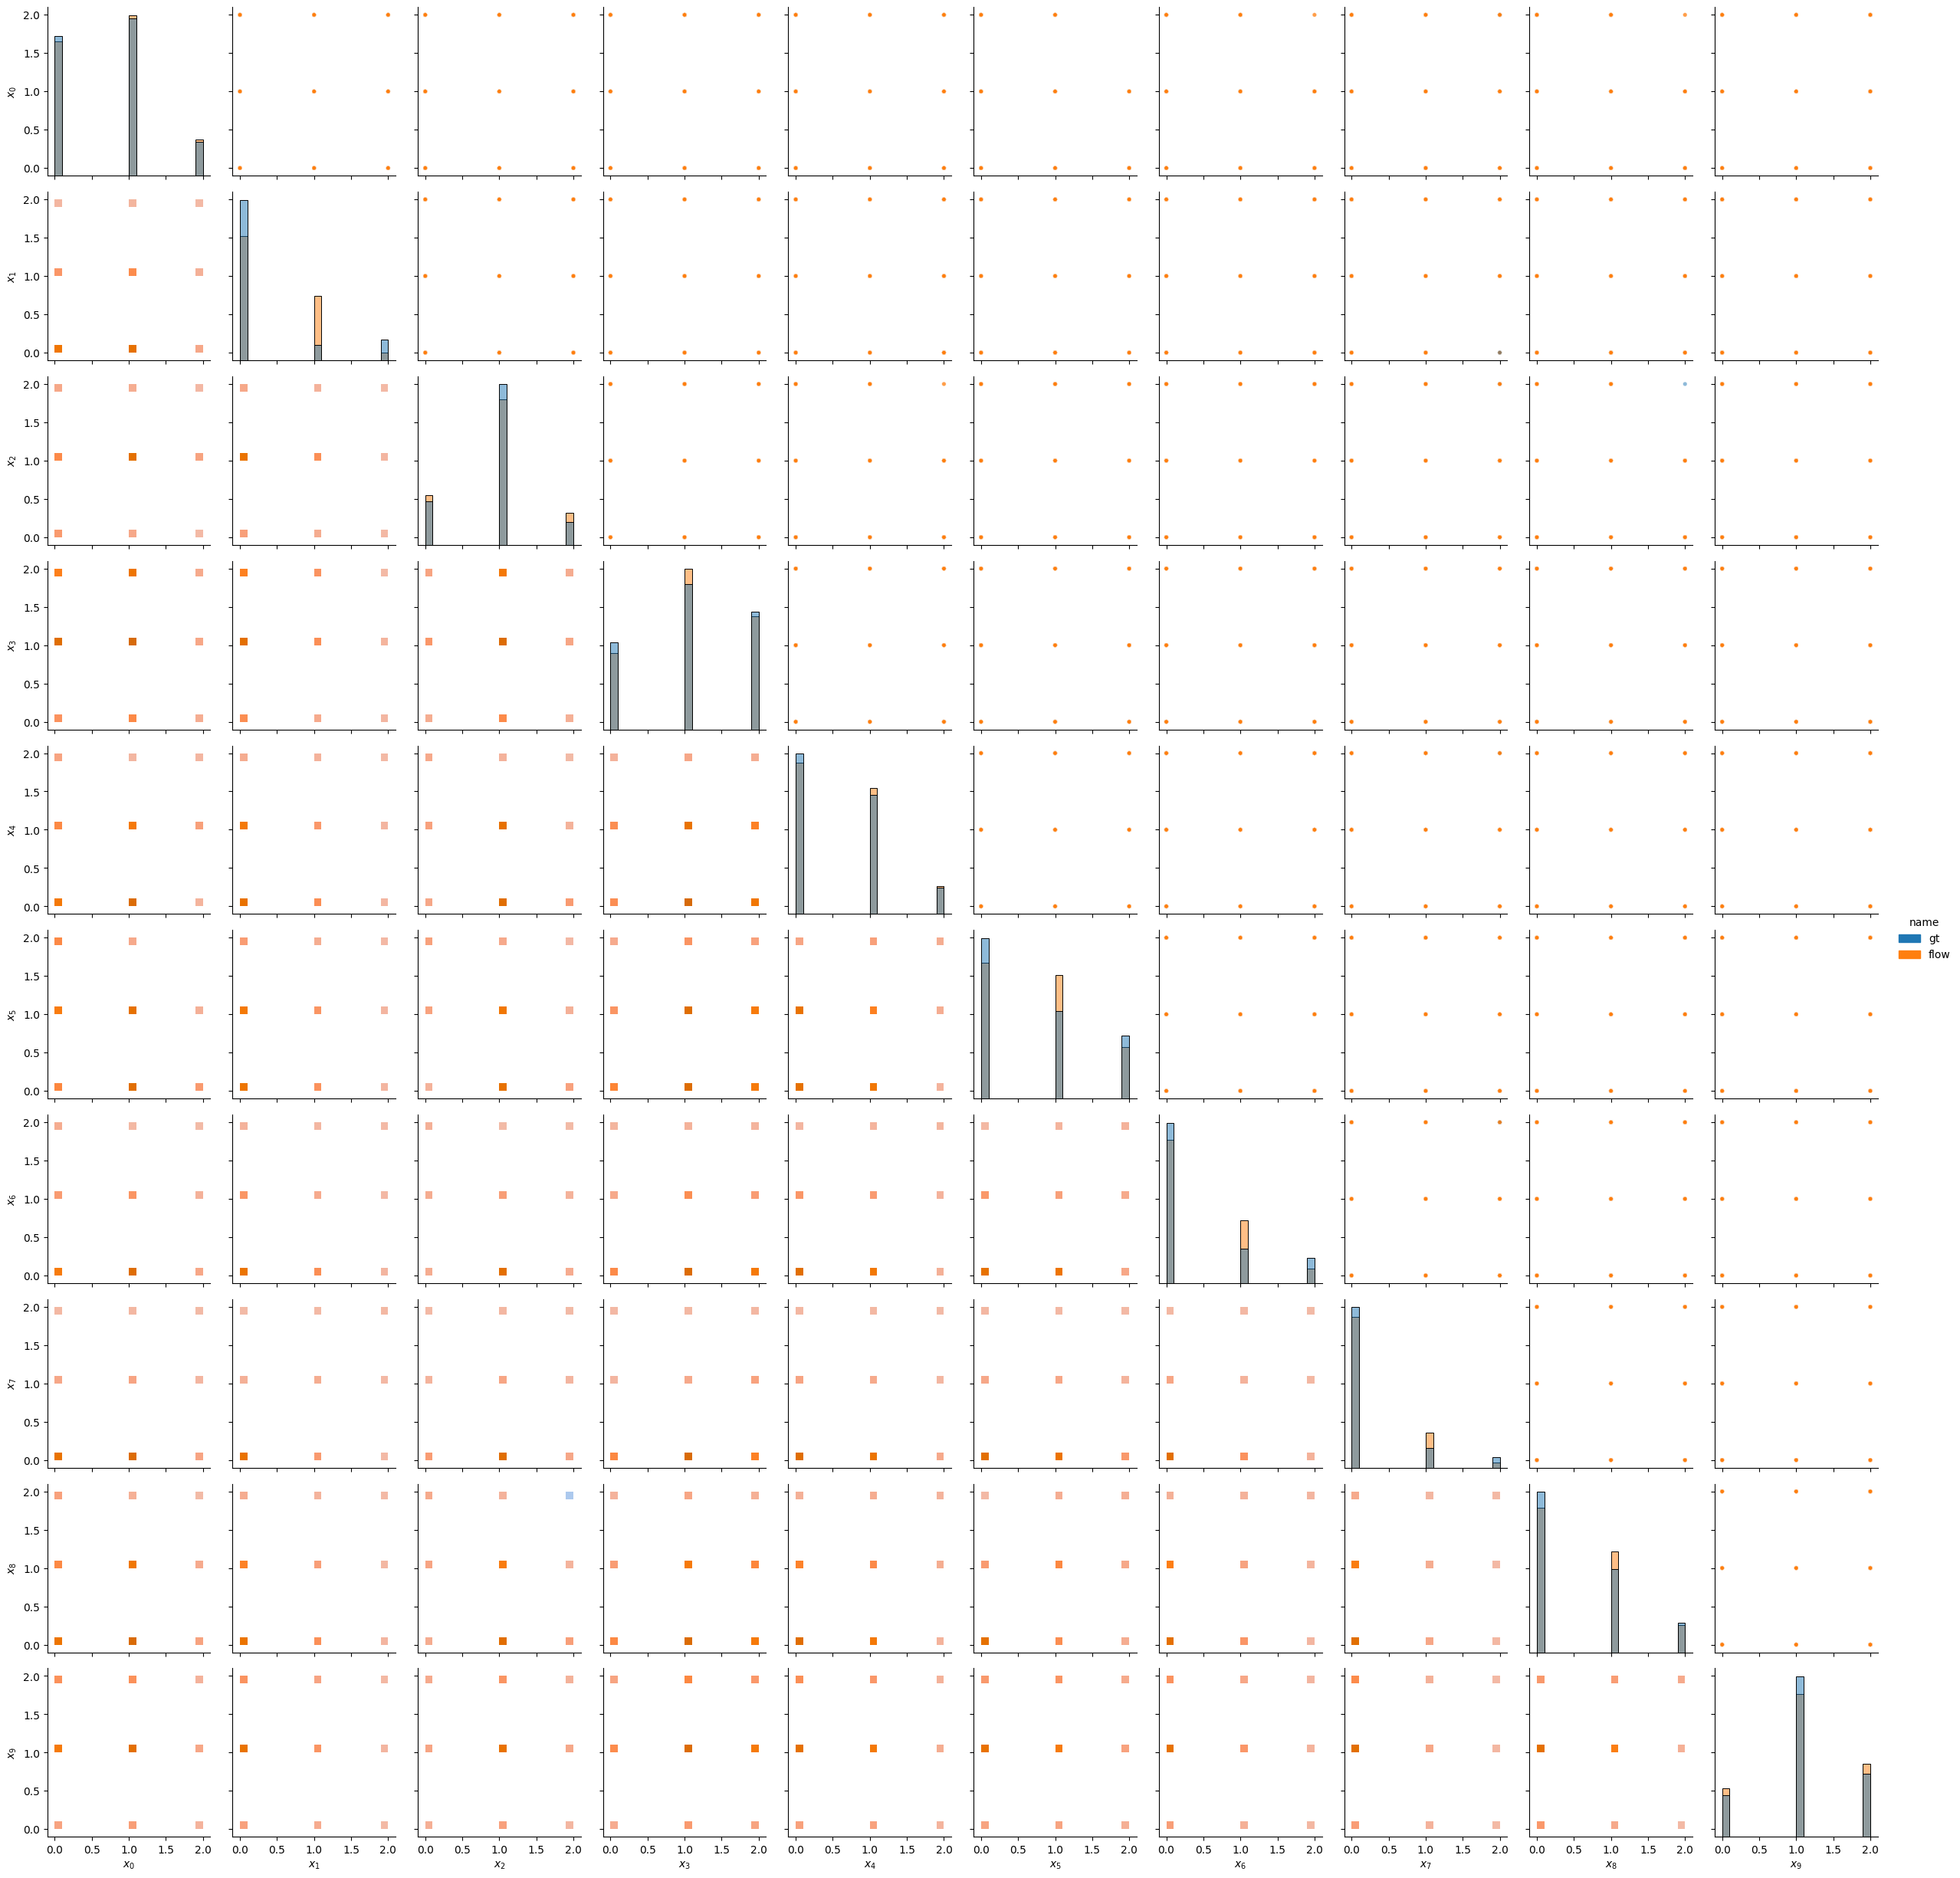

In [121]:
# observational
gt_obs = post_process(test_C_topo_deq, binary_dims, binary_min_values, binary_max_values)
obs_data =flow().sample([test_C_topo_deq.shape[0]])
obs_data = post_process(obs_data, binary_dims, binary_min_values, binary_max_values)

plot_data({'gt': gt_obs, 'flow': obs_data}, "hist")


interventional

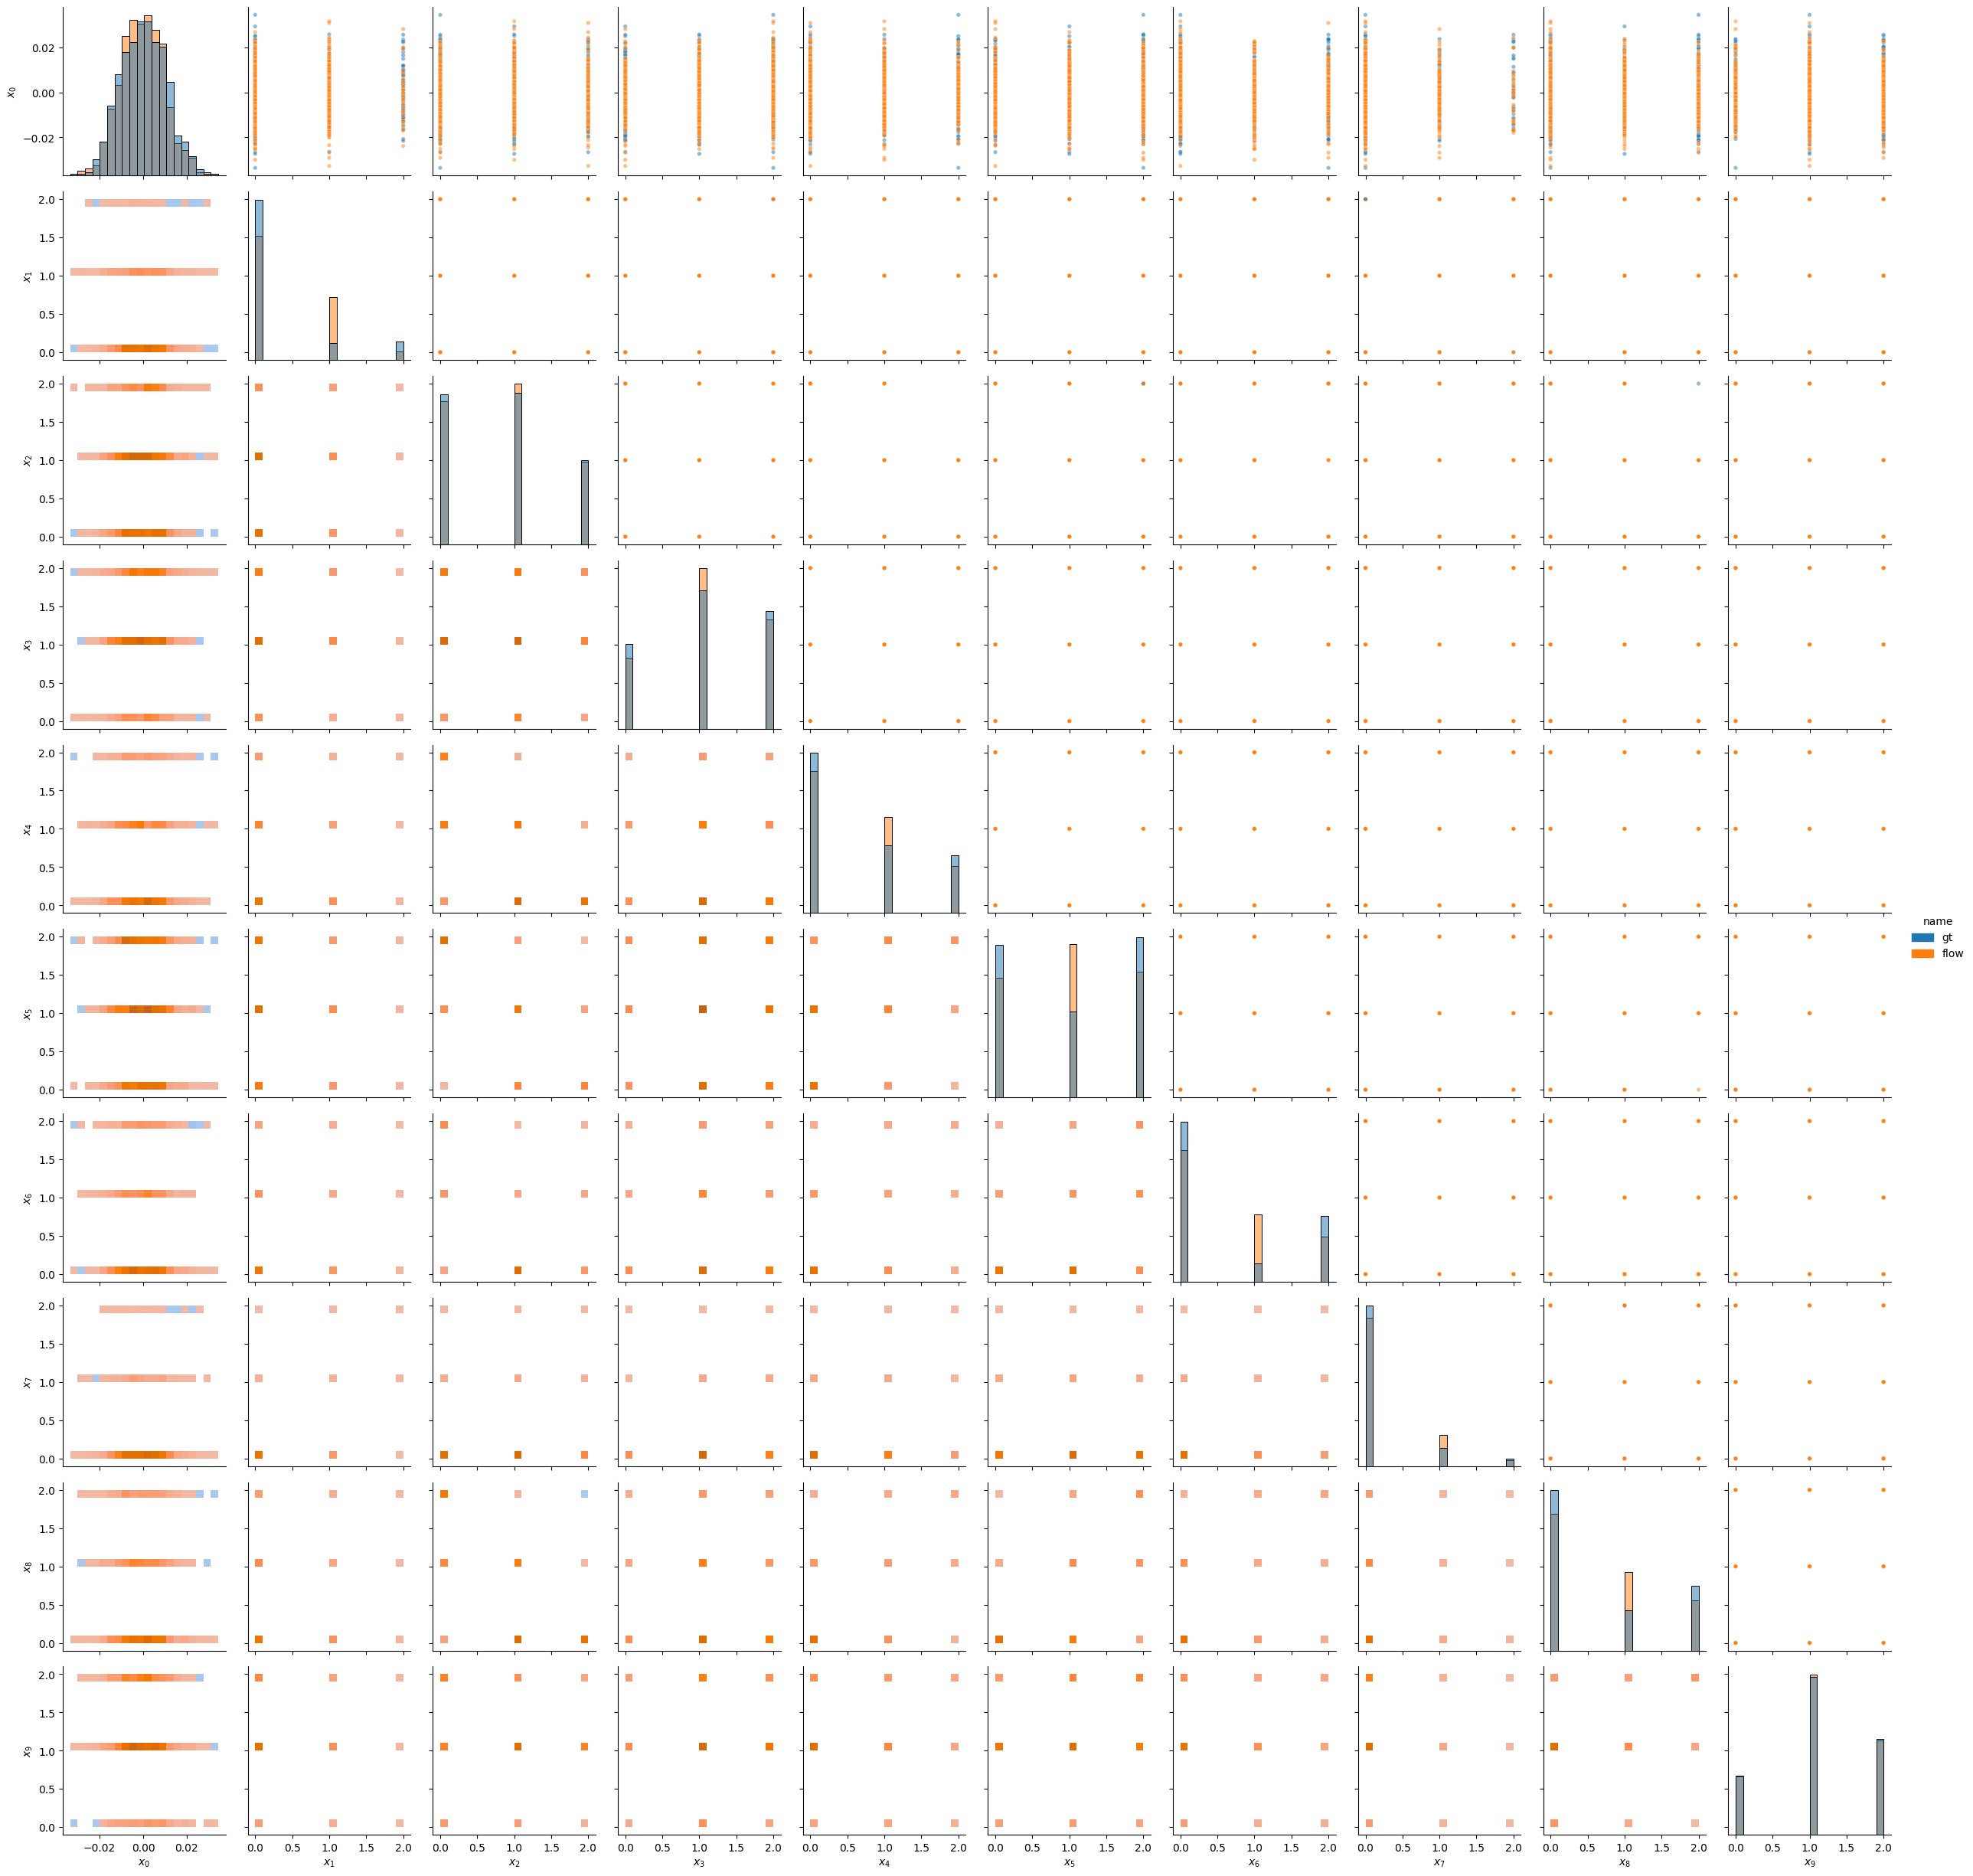

In [ ]:
# intervention
index, value = 0, 0

#"simple" ground truth : conditional on root is same as intervention on root
mask = test_C_topo_deq[..., index].floor() == int(value)
int_gt = test_C_topo_deq[mask, :]
int_gt = add_noise(post_process(int_gt, binary_dims, binary_min_values, binary_max_values))

#generate intervention data
int_data = flow().sample_interventional(index=0, value=0+torch.rand(1), sample_shape=(int_gt.shape[0],))
int_data = add_noise(post_process(int_data, binary_dims, binary_min_values, binary_max_values))

#plot
plot_data({'gt': int_gt, 'flow': int_data}, "hist")


counterfactual

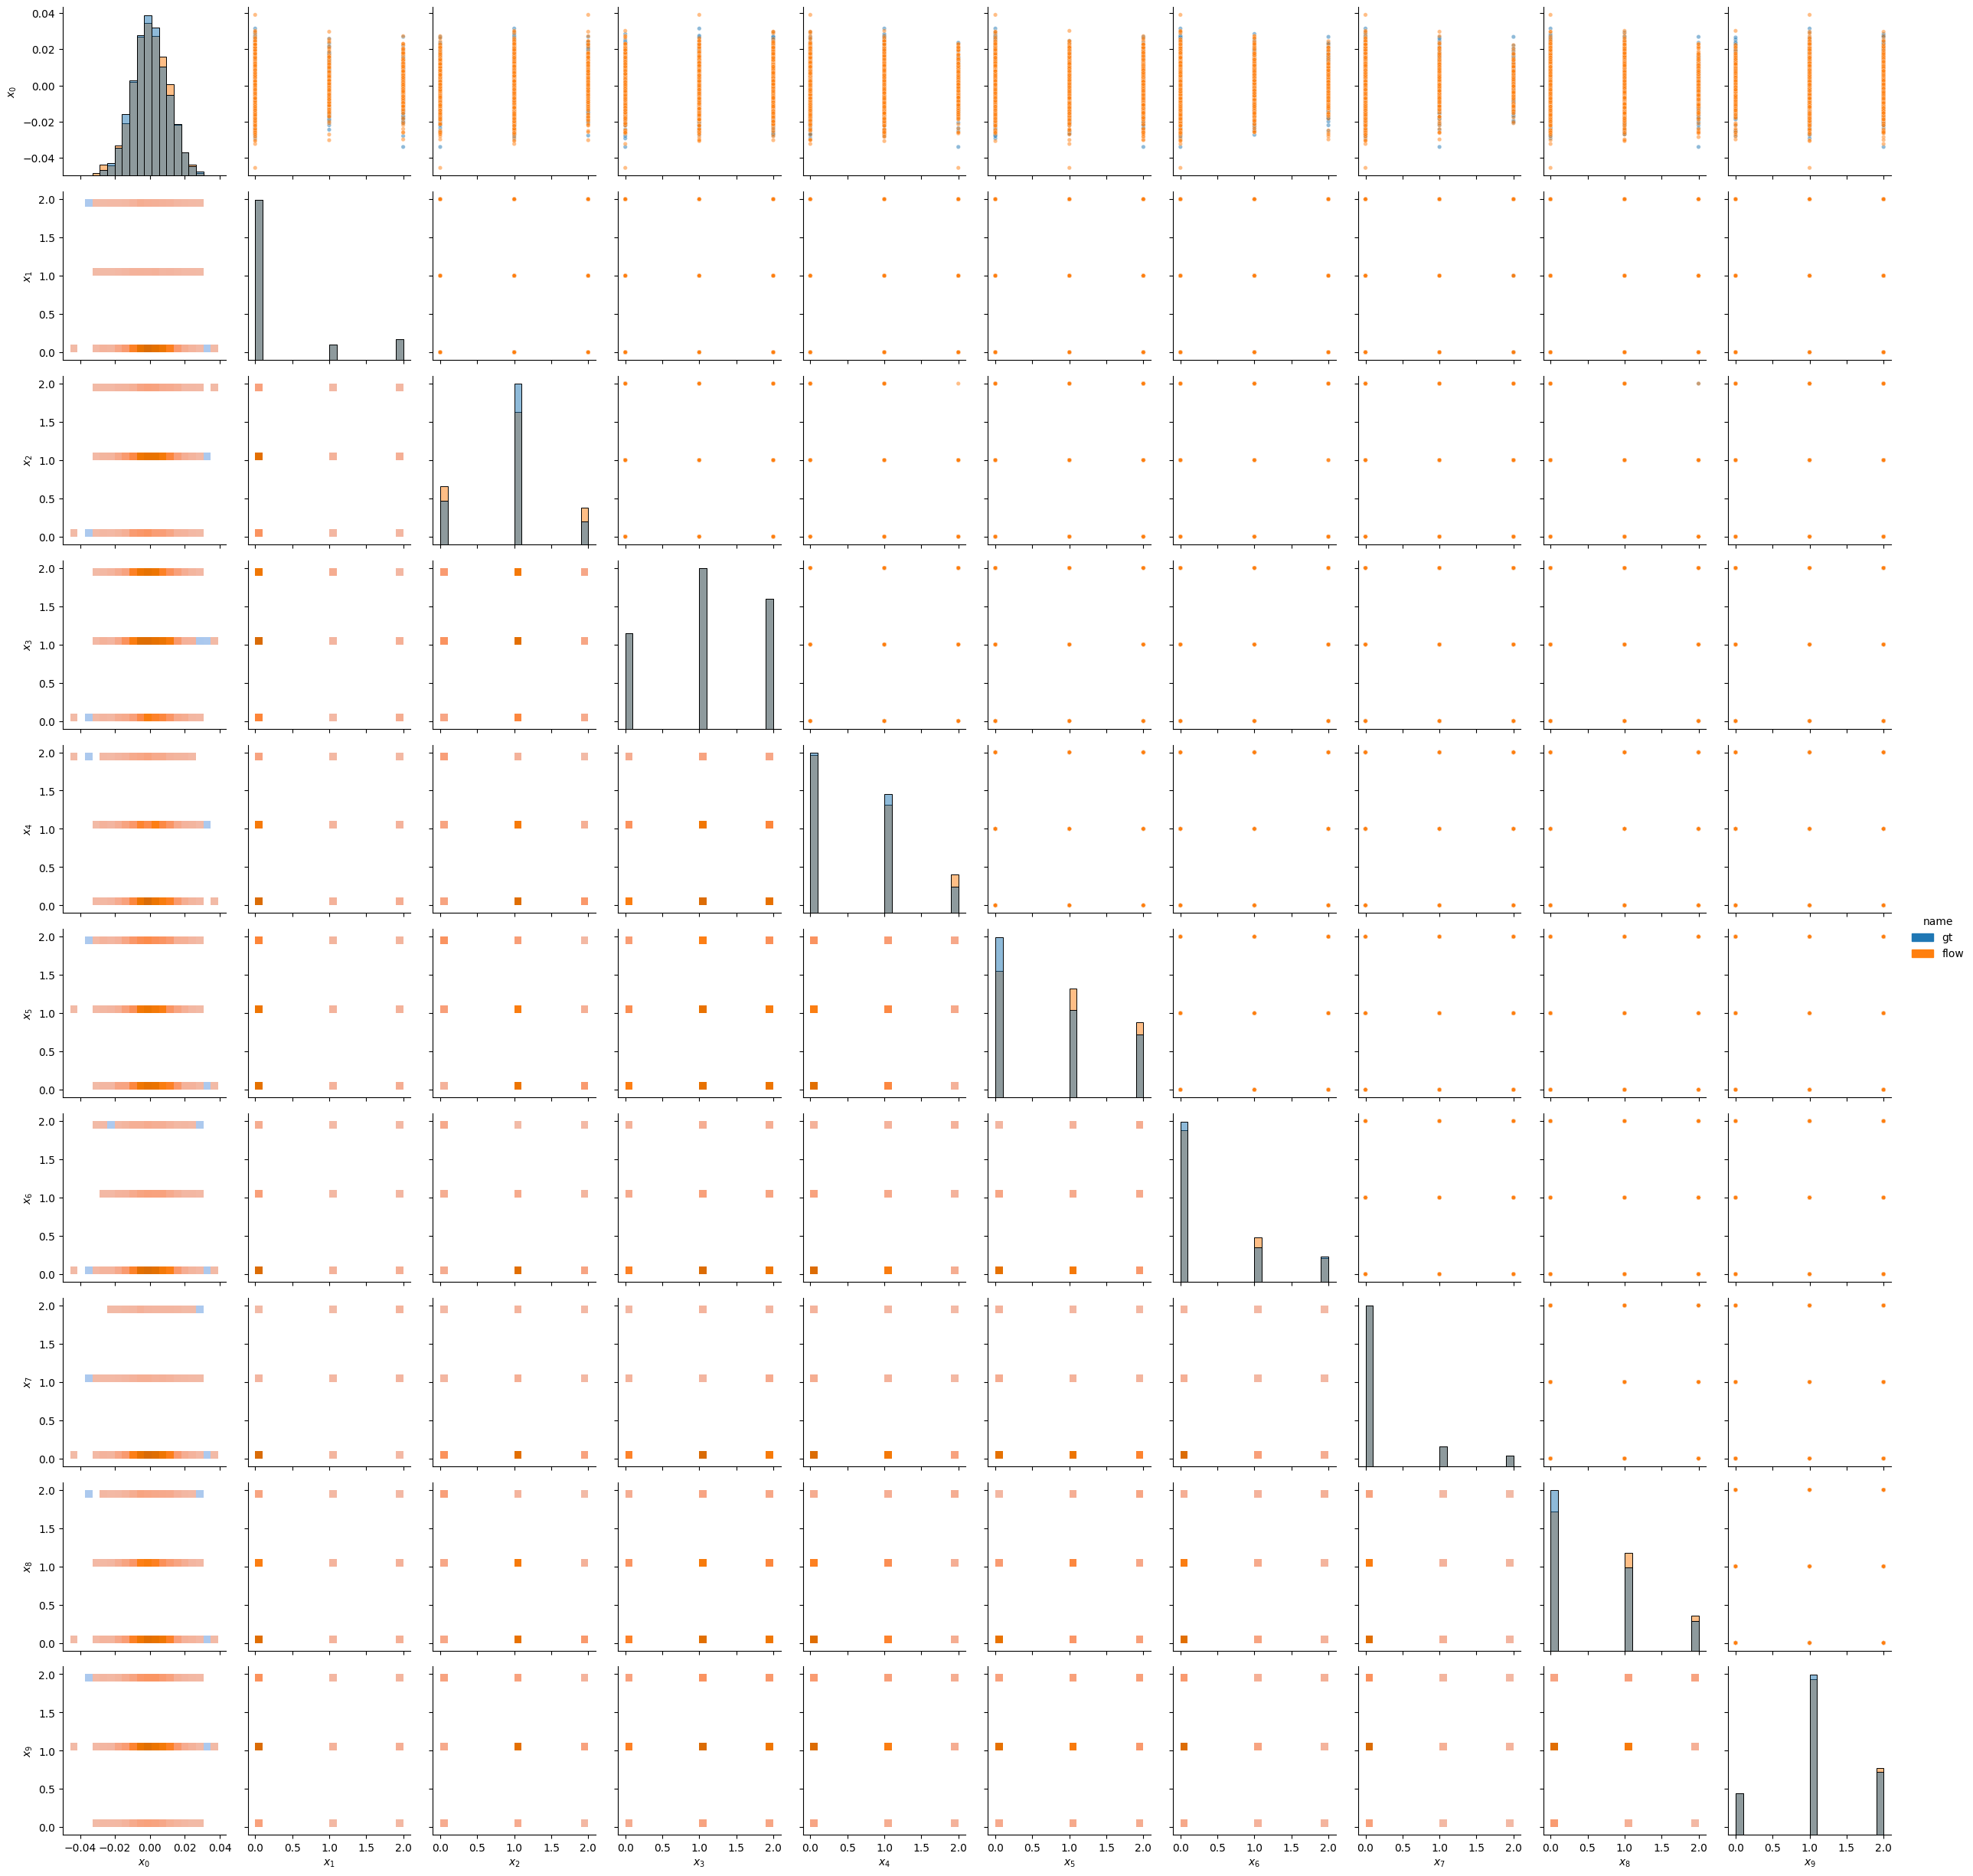

In [127]:
# intervention
index, value = 0, 0
x_cf = test_C_topo_deq.clone()


#"simple" ground truth : fixing value on root node of given factual data
cf_gt = x_cf.clone()
cf_gt[..., index] = value
cf_gt = add_noise(post_process(cf_gt, binary_dims, binary_min_values, binary_max_values))

#generate intervention data
cf_data = flow().compute_counterfactual(x_cf, index=0, value=0+torch.rand(1)).detach().cpu()
cf_data = add_noise(post_process(cf_data, binary_dims, binary_min_values, binary_max_values))

#plot
plot_data({'gt': cf_gt, 'flow': cf_data}, "hist")

## CBM, Causal Analysis.
* First, train vanilla, CBM or C2BM
* Then, extract 'predicted/inferenced' concept labels, corresponding to test dataset samples
* Analyzing distributional gaps between latent representations of true concepts and those derived from predicted concepts. (for 'Leakge analysis')
* Generate counterfactual concept predictions when given factual inputs, and apply them to (Causal)CBM as 'concept interventions' on test time

In [ ]:
# working on it...